In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

SAVE_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/semantic_segmentation/model/'  # モデルの保存先
IMAGES_PATH = '/content/drive/MyDrive/Colab Notebooks/semantic_segmentation/images/'

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

Mounted at /content/drive


In [2]:
import sys
import pprint

# モジュールのインポートが行えるようにパスを登録
sys.path.append('/content/drive/My Drive/Colab Notebooks/semantic_segmentation')
sys.path.append('/content/drive/My Drive/Colab Notebooks/semantic_segmentation/utils')

pprint.pprint(sys.path)

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/Colab Notebooks/semantic_segmentation',
 '/content/drive/My Drive/Colab Notebooks/semantic_segmentation/utils']


# データのダウンロード

In [3]:
import urllib.request
import zipfile
import tarfile

In [4]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [5]:
# VOC2012のデータセットをここからダウンロード
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

# 事前準備

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch

from utils.dataloader import make_datapath_list, DataTransform

In [7]:
# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=rootpath)

# ネットワークを読み込む

In [8]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load(f"{SAVE_MODEL_PATH}pspnet50_30_finetuning.pth", map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


# 推論実行

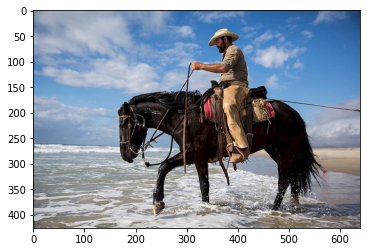

In [9]:
# 元画像の表示
image_file_path = f"{IMAGES_PATH}cowboy-757575_640.jpeg"
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

In [10]:
# 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475, color_mean=color_mean, color_std=color_std)

In [11]:
# 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

In [12]:
# PSPNetで推論する
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])

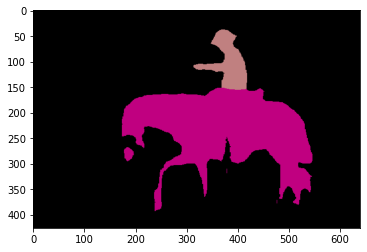

In [13]:
# PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

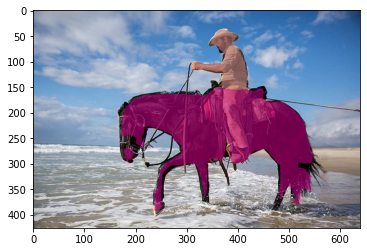

In [14]:
# 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()